# <b>Bayesify</b>
## analizing liked songs features using bayesian networks
Spotyfy's API provides lots of data about songs. I've made a tataset with my latest 500 liked songs, and 300 other songs that i dislike.<br>
This dataset will be analyzed using Bayesian Networks, trying to build a good model with causal relationship between the features of the dataset, and making inference with different methods.<br>


## <b>1. Dataset analysis</b>
First, the dataset is imported.

In [2]:
import pgmpy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#import dataset
data=pd.read_csv("spotifyData.csv")
#drop first column
data=data.drop(data.columns[0],axis=1)
genre_dict = { 1: 'country', 2:'trap',3:'edm', 4:'electronic', 5: 'funk', 6: 'rock', 7: 'hip hop', 8: 'soul', 9: 'r&b',  10: 'jazz', 11: "pop"}

    

c:\Users\gnele\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The values are discretized, as pgmpy does not fully support continuous values. <br>
Most of the features are continuous and between 0 and 1, so they have been multiplied by 100 and rounded down to the nearest integer, so the're now integer values ranging from 0 to 100.<br>
It's important to notice that Bayesian networks are not very much influenced by outliers, for that reason the data hasn't been scaled.

The following is a brief description of the meaning of the features in the dataset, taken by the official Spotify's API documentation page $^{[1]}$:
<i>

- <b>danceability</b><br>
Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0 is least danceable and 4 is most danceable.
- <b>energy</b><br>
Energy is a measure from 0 to 4 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
- <b>loudness</b><br>
The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db, but were mapped from 0 to 4.
- <b>acousticness</b><br>
A confidence measure from 0 to 4 of whether the track is acoustic. 4 represents high confidence the track is acoustic.
- <b>instrumentalness</b>:<br>
Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". It's a binary value where 1 indicates that the song is probably instrumental, 0 otherwais.
- <b>valence</b><br>
A measure from 0 to 4 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
- <b>tempo</b><br>
The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
</i>

<br>
<b>Like </b> and <b>Genre</b> have been added by me, the first is binary and 1 means I like the song, 0 otherwise.<br>
Genre is the main Genre of the artist mapped into the following dictionary:<br><br>

> {1: 'country', 2:'trap',3:'edm', 4:'electronic', 5: 'indie', 6: 'rock', 7: 'hip-hop', 8: 'soul', 9: 'r&b',  10: 'jazz', 11: "pop"}


Now let's take a look at the distribution of all the variables to get an idea of what we should expect.

In [3]:
#make all values integers
data=data.astype(int)
data

,danceability,energy,loudness,acousticness,instrumentalness,valence,tempo,genre,like
0,2,2,3,2,1,2,0,5,1
1,3,2,2,0,1,3,1,4,1
2,3,3,2,0,1,2,3,10,1
3,2,1,3,3,0,1,2,8,1
4,3,3,4,1,0,3,0,7,1
...,...,...,...,...,...,...,...,...,...
595,4,4,4,0,0,1,2,3,0
596,4,3,4,0,0,2,2,11,0
597,2,4,4,0,0,2,1,1,0
598,2,4,4,0,1,0,2,3,0


array([[<AxesSubplot: title={'center': 'danceability'}>,
        <AxesSubplot: title={'center': 'energy'}>,
        <AxesSubplot: title={'center': 'loudness'}>],
       [<AxesSubplot: title={'center': 'acousticness'}>,
        <AxesSubplot: title={'center': 'instrumentalness'}>,
        <AxesSubplot: title={'center': 'valence'}>],
       [<AxesSubplot: title={'center': 'tempo'}>,
        <AxesSubplot: title={'center': 'genre'}>,
        <AxesSubplot: title={'center': 'like'}>]], dtype=object)

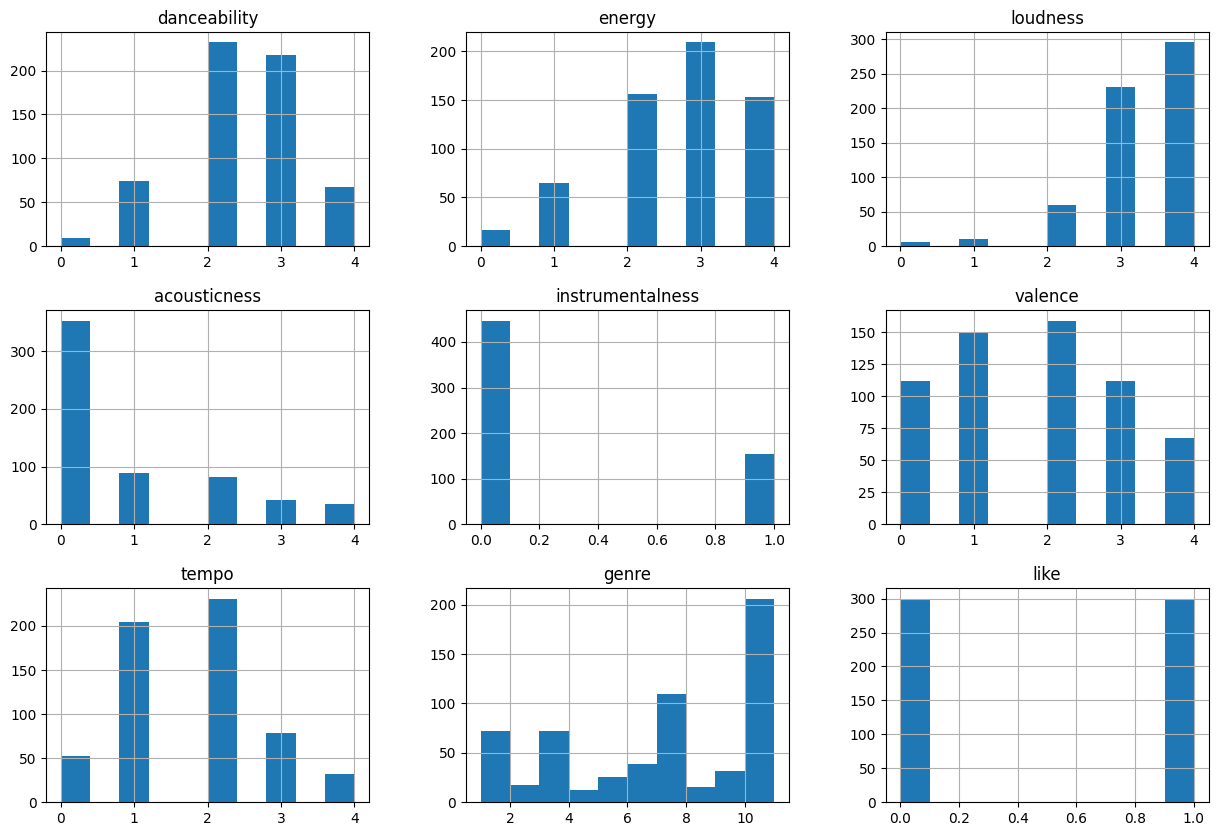

In [4]:
data.hist(figsize=(15,10))

Text(0.5, 1.0, 'plot for dislikes')

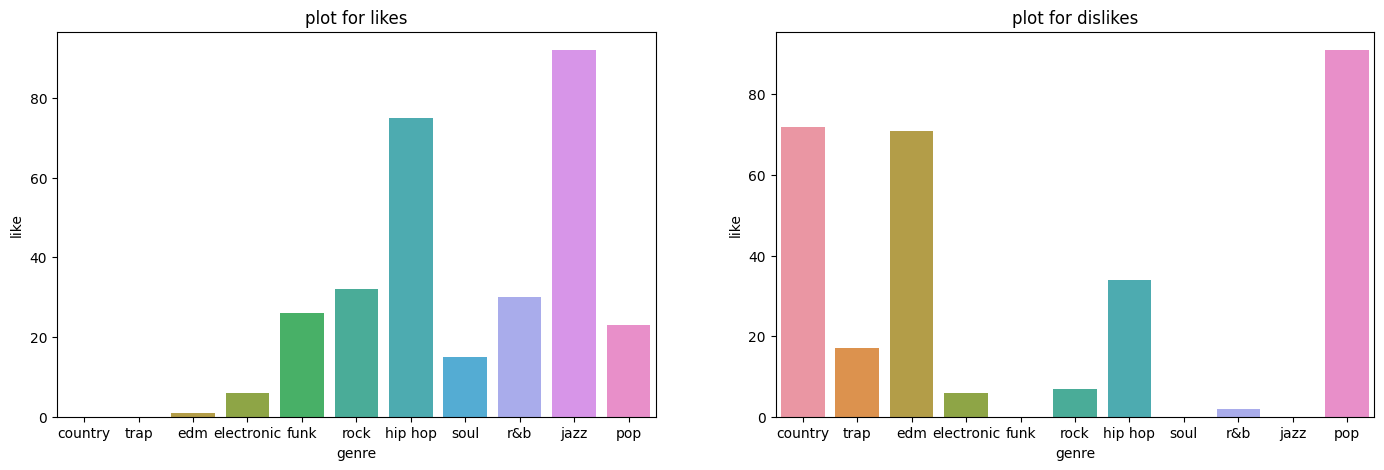

In [5]:
#remove warnings
import warnings
warnings.filterwarnings('ignore')

dfLike=pd.DataFrame(columns=['genre','like'])
dfDislike=pd.DataFrame(columns=['genre','like'])
#for each genre count the number of songs where like=1 and like==0
for i in range(1,len(genre_dict)+1):
    dfLike=dfLike.append({'genre':genre_dict[i],'like':sum(data[data['genre']==i]['like']==1)},ignore_index=True)
    dfDislike=dfDislike.append({'genre':genre_dict[i],'like':sum(data[data['genre']==i]['like']==0)},ignore_index=True)
#plot the number of likes for each genre
plt.figure(figsize=(17,5))
plt.subplot(1,2,1)
sns.barplot(x='genre',y='like',data=dfLike)
plt.title('plot for likes')
plt.subplot(1,2,2)
sns.barplot(x='genre',y='like',data=dfDislike)
plt.title('plot for dislikes')


## <b>2. Model Creation </b>
### <b>2.1 Using domain knowledge </b>

The model topology was made from the domain knowledge (given by the features description), the correlation analysis, and via trial and error

In [6]:
from pgmpy.models import BayesianNetwork
from pgmpy.base import DAG

custom_dag=DAG([('genre', 'like'), #("valence", "like"), 
            ("instrumentalness", "genre"), ("acousticness", "loudness"), ("loudness", "energy"), ("energy", "valence"),
            ("tempo", "danceability"), ("loudness", "genre"), ("danceability", "valence")])
custom_model = BayesianNetwork([('genre', 'like'), #("valence", "like"), 
            ("instrumentalness", "genre"), ("acousticness", "loudness"), ("loudness", "energy"), ("energy", "valence"),
            ("tempo", "danceability"), ("loudness", "genre"), ("danceability", "valence")])

We want to automatically learn the parameters for the `CPDs (Conditional Probability Distributions)` of the model, by analyzing the dataset with `Maximum Likelihood Estimation (MLE)`.<br>

In [7]:
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.estimators import BayesianEstimator
custom_model.fit(data, estimator=MaximumLikelihoodEstimator)

The graph below represents the network:

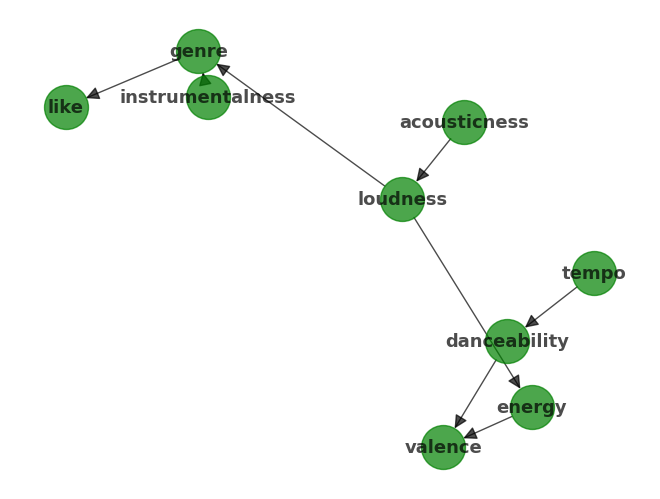

In [8]:
import networkx as nx
import pylab 
def print_network(model):
    nx_graph = nx.DiGraph(model.edges())
    nx.draw(nx_graph, with_labels=True, node_color='g', node_size=1000, alpha=0.7, arrowsize=20, font_size=13, font_weight='bold')
    plt.show()
print_network(custom_model)

### <b>2.2 Learning Bayesian Network structure </b>
Using hill climb search and BDeu Score, the network structure is learned automatically


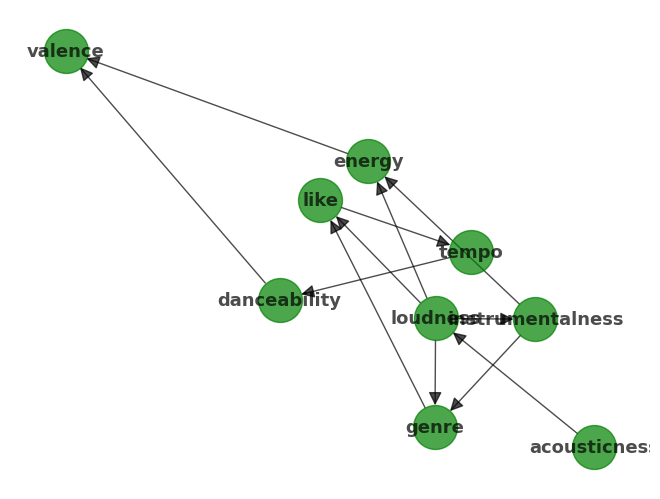

In [9]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BDeuScore
#create dag instance from custom_model

#hill climb search
hc = HillClimbSearch(data)
best_model = hc.estimate(scoring_method=BDeuScore(data), show_progress=False, start_dag=custom_dag, fixed_edges=custom_dag.edges )
print_network(best_model)


As we can see, the new model does not seem to understend correctly causality.

In [10]:
hc_model=BayesianNetwork(best_model.edges())
hc_model.fit(data, estimator=MaximumLikelihoodEstimator)

In [11]:
#comapre scores by using BDeuScore
from pgmpy.estimators import BDeuScore
print("BDeuScore for custom model: ", BDeuScore(data).score(custom_model))
print("BDeuScore for hill-climb search model: ", BDeuScore(data).score(hc_model))

BDeuScore for custom model:  -6439.986396841089
BDeuScore for hill-climb search model:  -6334.668699660096


Even if the values are similar, we get that the hill-climb search model is actually better (best fits the data).

## <b>3. Network analysis</b>


In [12]:
#sampling
from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State
infer_appr=BayesianModelSampling(custom_model)
q_appr=infer_appr.rejection_sample(evidence= [State('like', 1), State("instrumentalness",1)], size=10000, show_progress=False)
q_appr.value_counts('genre')

genre
10    5468
7     1617
6     1072
11     847
5      431
9      297
8      250
4       18
dtype: int64

In [13]:
print(custom_model.get_cpds("genre"))
print(custom_model.get_cpds("genre").values)

+------------------+-----+---------------------+
| instrumentalness | ... | instrumentalness(1) |
+------------------+-----+---------------------+
| loudness         | ... | loudness(4)         |
+------------------+-----+---------------------+
| genre(1)         | ... | 0.0                 |
+------------------+-----+---------------------+
| genre(2)         | ... | 0.0                 |
+------------------+-----+---------------------+
| genre(3)         | ... | 0.5666666666666667  |
+------------------+-----+---------------------+
| genre(4)         | ... | 0.06666666666666667 |
+------------------+-----+---------------------+
| genre(5)         | ... | 0.0                 |
+------------------+-----+---------------------+
| genre(6)         | ... | 0.03333333333333333 |
+------------------+-----+---------------------+
| genre(7)         | ... | 0.1                 |
+------------------+-----+---------------------+
| genre(8)         | ... | 0.0                 |
+------------------+

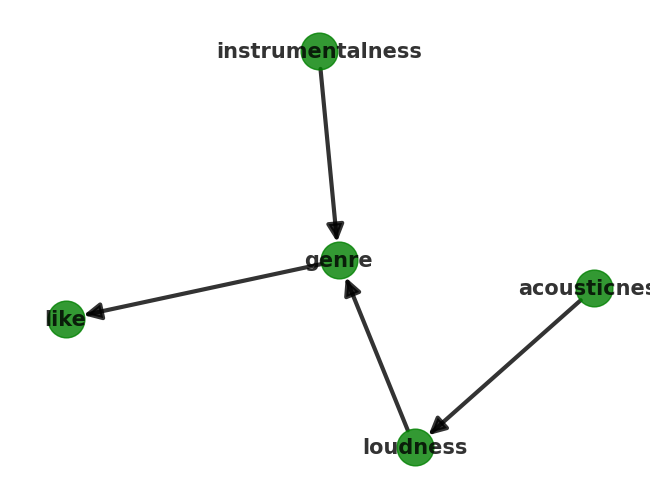

In [14]:
#analyze irrelevant nodes for "like" (nodes not part of the ancestor set of "like")

ancestral_graph_like=custom_model.get_ancestral_graph("like")
nx_graph2 = nx.DiGraph(ancestral_graph_like.edges())
nx.draw(nx_graph2, with_labels=True, node_color='g', node_size=700, alpha=0.8, arrowsize=25, font_size=15, font_weight='bold', width=3)
plt.show()
# arrowstyle can be: fhead, lhead, rhead, chead, xhead, ohead, head, plain, curve, box, diamond, vee, larrow, rarrow, and none

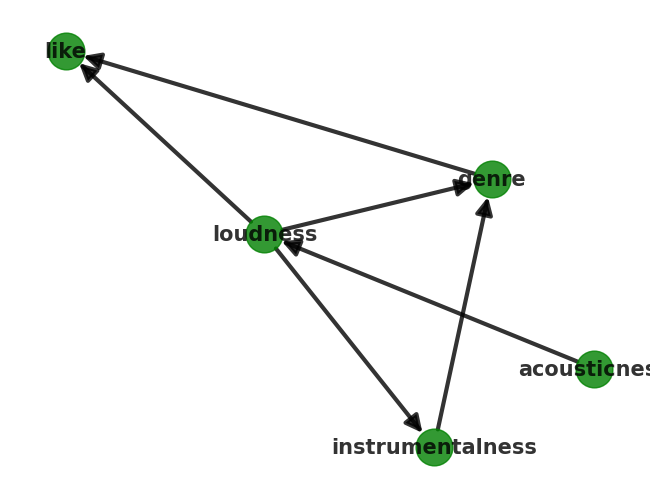

In [15]:
#ancestral graph for best_model
ancestral_graph_like=hc_model.get_ancestral_graph("like")
nx_graph2 = nx.DiGraph(ancestral_graph_like.edges())
nx.draw(nx_graph2, with_labels=True, node_color='g', node_size=700, alpha=0.8, arrowsize=25, font_size=15, font_weight='bold', width=3)
plt.show()


## <b>4. Inference</b>
Different queries are performed to infer the probability of certain features. Then, for each of them, different models/methods are tested and compared.<br>
Below is a function responsible of plotting a histogram of the results.


In [16]:
def plot_inference(queries, target, model, size=(10,5)):
    plt.figure(figsize=size)
    df=pd.DataFrame(columns=[target,'probability', 'model'])

    for q,m in zip(queries, model):
        #get the number of states for the target variable
        n_var=q.get_cardinality([target])[target]
        for i in range(n_var):
            name=q.get_state_names(target, state_no=i)
            if target=='genre':
                name=genre_dict[name]
            df=df.append({target:name, 'probability':q.values[i], "model":m},ignore_index=True)
        #plot the results
    sns.barplot(x=target,y='probability',data=df, hue="model")

### <b>4.1. Exact inference</b>
Using Varuable Elimination and belief propagation

100%|██████████| 100/100 [00:00<00:00, 2488.32it/s]


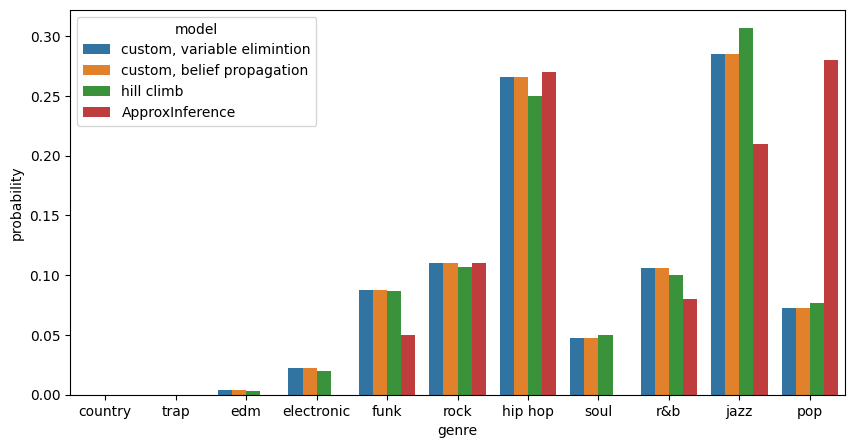

In [17]:
# make inference
from pgmpy.inference import VariableElimination
from pgmpy.inference import ApproxInference
from pgmpy.inference import BeliefPropagation

evidence={"like":1}
var=['genre']

#custom Variable elimination
infer_custom_ve=VariableElimination(custom_model)
q_custom_ve = infer_custom_ve.query(variables=var, evidence=evidence)
#custim belief propagation
infer_custom_bp=BeliefPropagation(custom_model)
q_custom_bp = infer_custom_bp.query(variables=var, evidence=evidence)
#hill climb
infer_hc=VariableElimination(hc_model)
q_hc= infer_hc.query(variables=var, evidence=evidence)
#approximate inference
infer_appr=ApproxInference(custom_model)
q_appr=infer_appr.query(variables=var, evidence=evidence, n_samples=100, show_progress=True)

plot_inference([q_custom_ve,q_custom_bp,q_hc, q_appr], 'genre', ['custom, variable elimintion', "custom, belief propagation",'hill climb', "ApproxInference"])



NOTE: PGMpy uses Rejection Sampling when performing approximate inference $^{[1]}$ (when evidence is provided, like in this case)

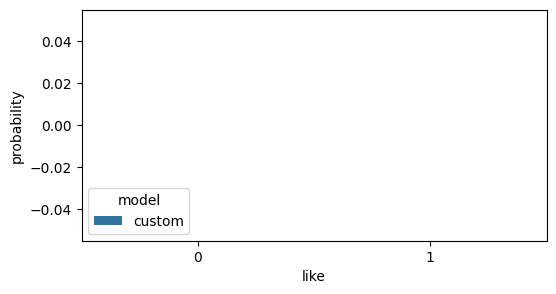

In [18]:
evidence={'danceability': 2.0, 'energy': 2.0, 'loudness': 2.0, 'acousticness': 2.0, 'genre': 2.0}
infer_custom=VariableElimination(custom_model)
q_custom=infer_custom.query(variables=['like'], evidence=evidence)

plot_inference([q_custom], 'like', ['custom'], size=(6,3))

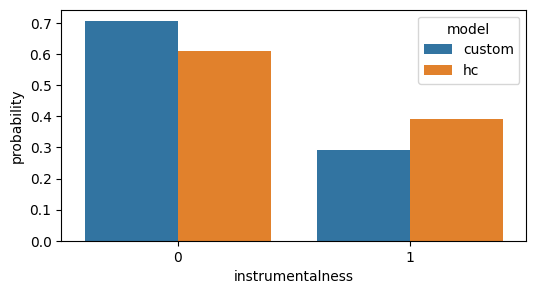

In [19]:
var=["instrumentalness"]
evidence={"like":1}
q_custom=infer_custom.query(variables=var, evidence=evidence)
infer_hc=VariableElimination(hc_model)  
q_hc=infer_hc.query(variables=var, evidence=evidence)
plot_inference([q_custom, q_hc], 'instrumentalness', ['custom', "hc"], size=(6,3))

Belief propagation

For this experiment, we get an unexpected result: pop music (genre 11), gets a higher score than jazz music. This could probably be related to the fact that pop music is the most present class in the dataset.

In [20]:
infer=ApproxInference(custom_model)

q = infer.query(variables=['genre'], evidence={"like":1}, show_progress=True, n_samples=10)
print(q)

100%|██████████| 10/10 [00:00<00:00, 140.89it/s]

+-----------+--------------+
| genre     |   phi(genre) |
+===========+==============+
| genre(5)  |       0.1000 |
+-----------+--------------+
| genre(6)  |       0.1000 |
+-----------+--------------+
| genre(7)  |       0.2000 |
+-----------+--------------+
| genre(9)  |       0.2000 |
+-----------+--------------+
| genre(10) |       0.1000 |
+-----------+--------------+
| genre(11) |       0.3000 |
+-----------+--------------+


By reducing the parameter n_samples to 10, genre 10 (jazz) gets a higher score that pop (as expected), but still genre 11 has a much higher score compared to the result obtained with exact inference.

# 5. Use case example
given a song name and artist, perform inference from features the likelyhood percentage that I like it.


In [21]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id,
                                                           client_secret=client_secret,
                                                           redirect_uri="http://localhost:8888/callback",
                                                           scope="user-library-read"))

#function to preprocess the data, taken from Dataset.ipynb without the like feature
def preprocessing(track_features):
    rawData=pd.read_csv("RawData.csv")
    #transform to dataframe
    df=(pd.DataFrame(track_features))
    df["like"]=1
    #feature selection
    df.drop(['type','id','uri','track_href','analysis_url','time_signature', 'key', 'mode', 'speechiness', 'liveness', 'duration_ms'],axis=1,inplace=True)
    # scale data with minmaxscaler
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    #add df to rawData as last entry
    rawData=rawData.append(df, ignore_index=True)                    
    rawData[['loudness', 'valence', 'acousticness', 'danceability', 'energy', 'tempo']] = scaler.fit_transform(rawData[['loudness', 'valence', 'acousticness', 'danceability', 'energy', 'tempo']])
 
    # discretization using sklearn.preprocessing.KBinsDiscretizer
    from sklearn.preprocessing import KBinsDiscretizer
    est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
    rawData['loudness'] = est.fit_transform(rawData[['loudness']])
    rawData['valence'] = est.fit_transform(rawData[['valence']])
    rawData['acousticness'] = est.fit_transform(rawData[['acousticness']])
    rawData['danceability'] = est.fit_transform(rawData[['danceability']])
    rawData['energy'] = est.fit_transform(rawData[['energy']])
    rawData['tempo'] = est.fit_transform(rawData[['tempo']])
    rawData['instrumentalness']= rawData["instrumentalness"].apply(lambda x: 1 if x>0.25 else 0)
    #return final dataframe
    df=rawData.tail(1)
    rawData=0
    df=df.drop(['like'], axis=1)
    df=df.drop(df.columns[0], axis=1)
    return df

def enumerate_genre(genres):
    genre_dict = { 1: 'country', 2:'trap',3:'edm', 4:'electronic', 5: 'funk', 6: 'rock', 7: 'hip hop', 8: 'soul', 9: 'r&b',  10: 'jazz', 11: "pop"}
    g=0
    for genre in genres:
        for key, value in genre_dict.items():
            if value in genre:
                g = key
        if g!=0:
            break
    return g

#function to get the track features from spotify given song name and artist
def retrieve_song(song_name, artist_name, verbose=False):
    #get the track id
    try:
        track_id = sp.search(q='track:' + song_name + ' artist:' + artist_name, type='track')
        track_id = track_id['tracks']['items'][0]['id']
    except:
        raise Exception("Error: song not found")
    #get the track features
    track_features = sp.audio_features(track_id)
    #add genre
    artist_id=sp.track(track_id)['artists'][0]['id']
    track_genre =sp.artist(artist_id)['genres']
    if verbose:
        print("artist genres:", track_genre)
    g=enumerate_genre(track_genre)
    #check if g is NaN
    if(g!=0 and g!=np.nan):
        track_features[0]['genre']=g
    #preprocess the data
    df= preprocessing(track_features)
    return df

def inference(name, artist, verbose=False):
    df_song=retrieve_song(name, artist, verbose)
    #transform the dataframe to a dictionary
    song_dict=df_song.to_dict(orient='records')[0]
    if verbose:
        print("dictionary of song features: ", song_dict, "\n")
    #perform inference
    infer=VariableElimination(custom_model)
    q = infer.query(variables=['like'], evidence=song_dict)
    print(q)
    plot_inference([q], 'like', ['custom'], size=(6,3))

    print("There is a {:.2f}% chance that I will like '{}' by '{}'".format(q.values[1]*100, name, artist))

In [22]:
name="Boredom"
artist="Tyler, the Creator"
inference(name, artist, verbose=True)


# references
1. [Spotify API documentation](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features)
2. [PGMpy Sampling source code](https://pgmpy.org/_modules/pgmpy/models/BayesianNetwork.html#BayesianNetwork.simulate)
3. [PGMpy rejection sampling source code](https://pgmpy.org/_modules/pgmpy/sampling/Sampling.html#BayesianModelSampling.rejection_sample)
